In [11]:
file_prefix <- "ch16.3"
reuse_fit <- T
source("preset.R")

input_file <- "data/TwoGroupIQ.csv"
RopeMuDiff=c(-0.5,0.5) ; RopeSdDiff=c(-0.5,0.5) ; RopeEff=c(-0.1,0.1)

In [3]:
data <- read_csv("data/TwoGroupIQ.csv") %>% 
  mutate(x = as.integer(factor(Group)))
values <- data$Score
stan_data <- list(
  N = length(values), 
  x = data$x, 
  y = values, 
  y_mean = mean(values), 
  y_sd = sd(values)
)

Parsed with column specification:
cols(
  Score = col_double(),
  Group = col_character()
)



In [6]:
init <- function() {
  list(
    mu = rnorm(2, mean(values), sd(values) * 2), 
    sigma = runif(n = 2, sd(values) / 1000, sd(values) * 1000), 
    nu_minus_one = runif(1, 0, 60)
  )
}
fit <- stan(file = "model/ch16.3.stan", data = stan_data, init = init, seed = 1234, 
            chains = 4, warmup = 200, iter = 5400, thin = 1)

In [4]:
#save(fit, file = save_file_name("fit"))
load(file = save_file_name("fit"))

In [5]:
fit

Inference for Stan model: ch16.
4 chains, each with iter=5400; warmup=200; thin=1; 
post-warmup draws per chain=5200, total post-warmup draws=20800.

                mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff
mu[1]          99.24    0.01 1.81   95.70   98.04   99.24  100.45  102.79 17415
mu[2]         107.16    0.02 2.71  101.85  105.35  107.16  108.96  112.49 20866
sigma[1]       11.35    0.01 1.74    8.32   10.13   11.22   12.44   15.08 17727
sigma[2]       17.99    0.02 2.72   13.06   16.08   17.87   19.74   23.69 18938
nu_minus_one    2.91    0.01 1.70    0.96    1.84    2.53    3.54    7.02 14389
nu              3.91    0.01 1.70    1.96    2.84    3.53    4.54    8.02 14389
lp__         -451.36    0.02 1.62 -455.34 -452.22 -451.03 -450.17 -449.21  9506
             Rhat
mu[1]           1
mu[2]           1
sigma[1]        1
sigma[2]        1
nu_minus_one    1
nu              1
lp__            1

Samples were drawn using NUTS(diag_e) at Wed Jan 15 22:30:09 2020

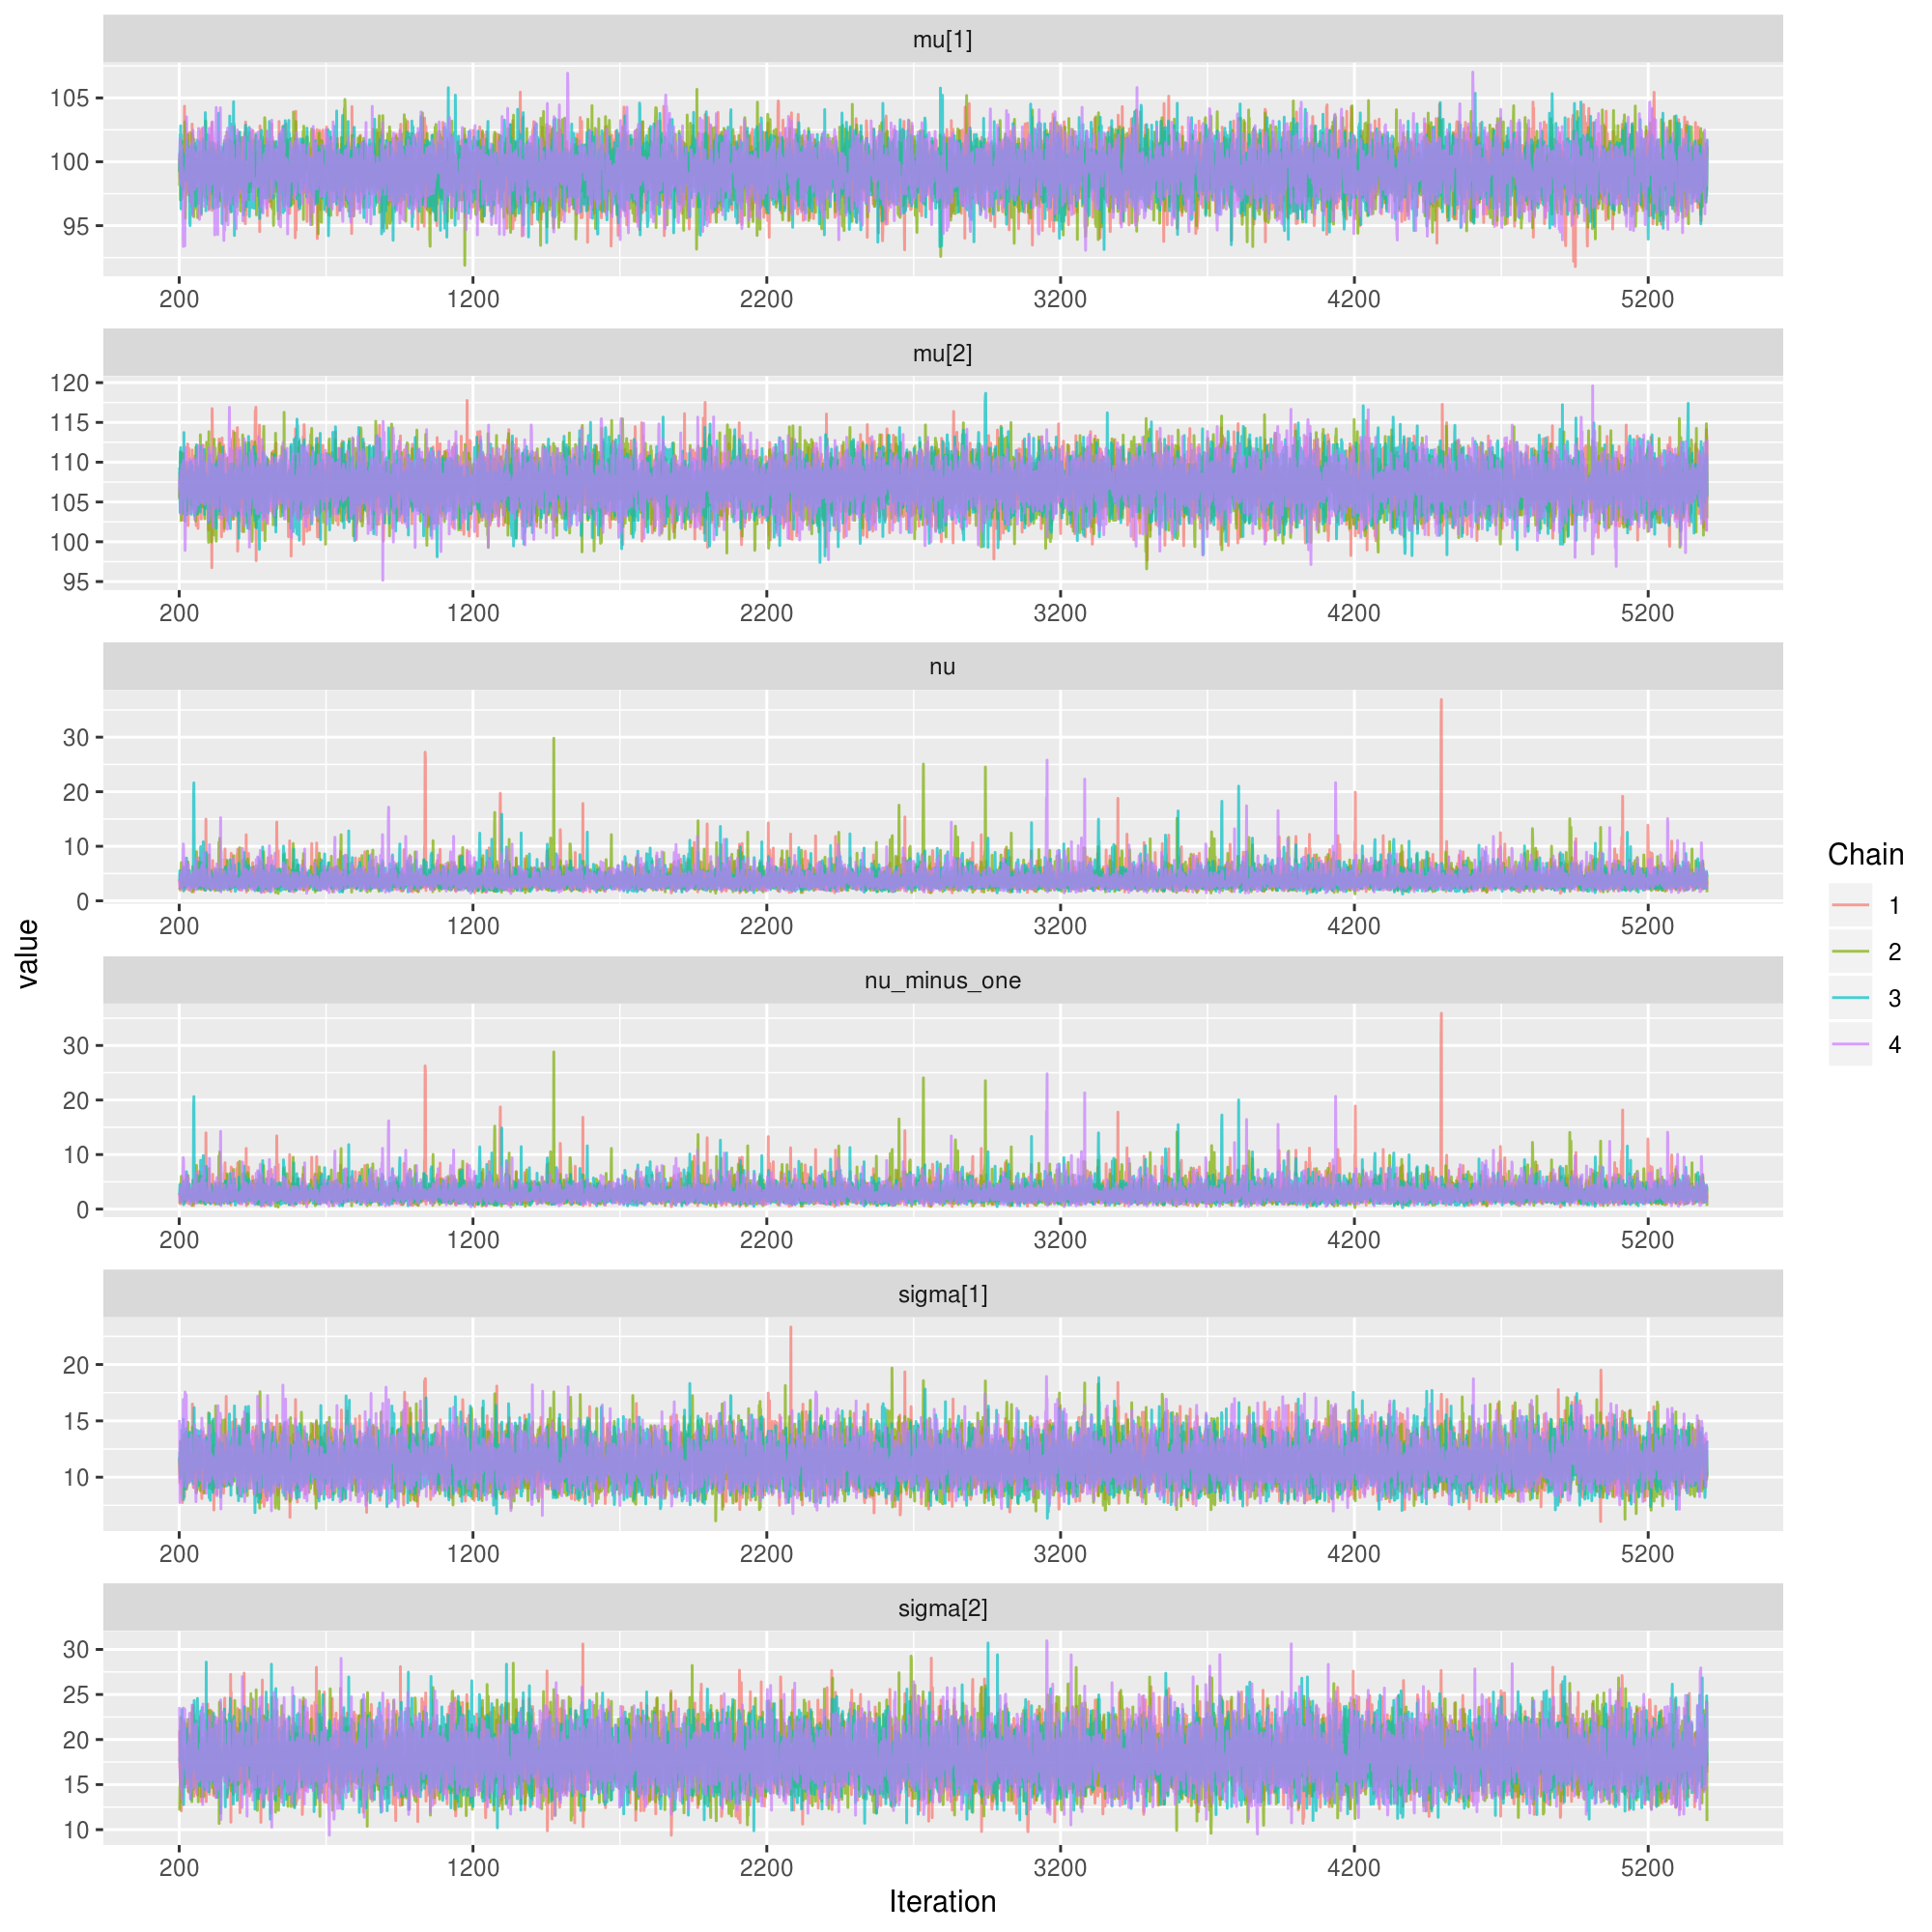

In [6]:
set_plot_size(10, 10)
ggs_traceplot(ggs(fit, inc_warmup = F))

In [7]:
#ggmcmc(ggs(fit), file = paste0(file_prefix, "_diag.pdf"))

In [8]:
# check posteria
res <- fit_to_tibble(fit) %>% 
  mutate(
    diff = mu_2 - mu_1, 
    sigma_diff = sigma_2 - sigma_1, 
    effect_size = (mu_2 - mu_1) / sqrt((sigma_1 ^ 2 + sigma_2 ^ 2) / 2)
  )

In [9]:
make_density <- function(values, idx, mu, sigma, nu) {
  normed_mu = (values - mu[idx]) / sigma[idx]
  dt(normed_mu, df = nu[idx]) / sigma[idx]
}
make_density1 <- function(values, idx) { make_density(values, idx, res$mu_1, res$sigma_1, res$nu) }
make_density2 <- function(values, idx) { make_density(values, idx, res$mu_2, res$sigma_2, res$nu) }

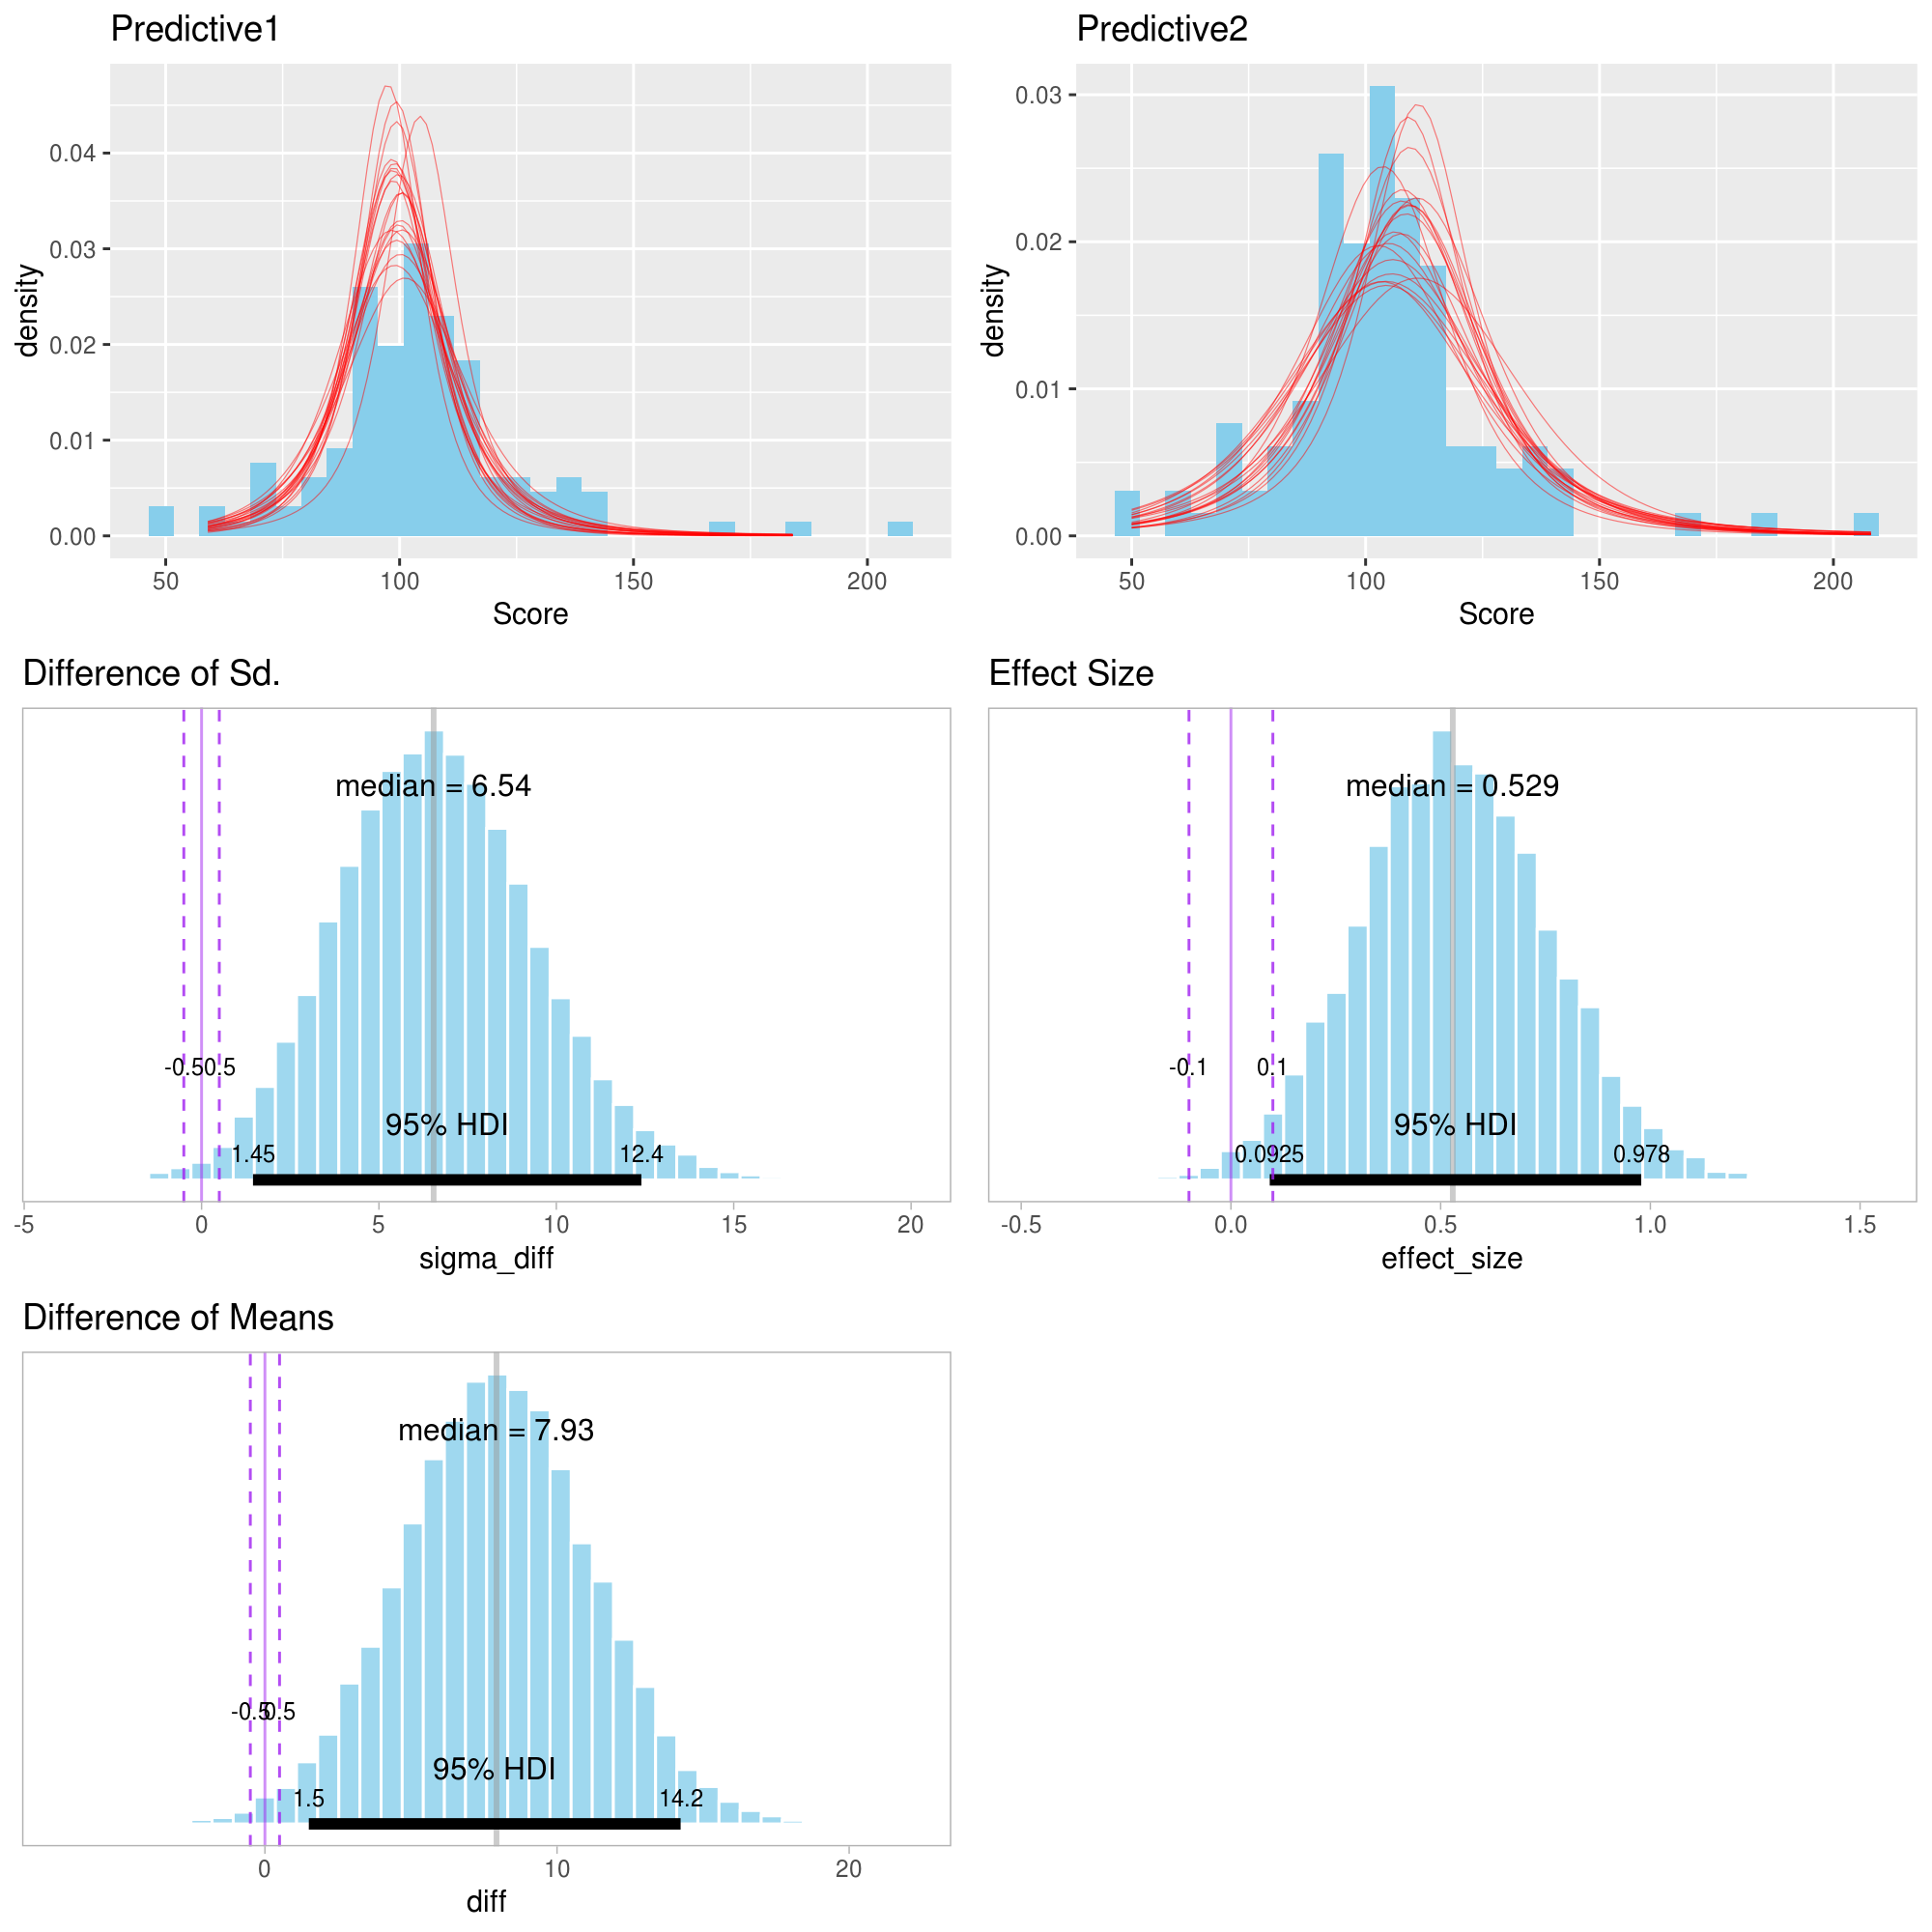

In [12]:
grid.arrange(
  #plot_post(res, "mu[1]", title = "Placebo Mean"), 
  #plot_post(res, "mu[2]", title = "Smart Drug Mean"), 
  #plot_post(res, "sigma", rope = c(14, 16), title = "Scale"), 
  #plot_post(res, "log_nu", title = "Normality"), 
  plot_post_predictive_with_histogram(
    filter(data, x == 1)$Score, make_density1, data = data, sample_len = dim(res)[1], title = "Predictive1"), 
  plot_post_predictive_with_histogram(
    filter(data, x == 2)$Score, make_density2, data = data, sample_len = dim(res)[1], title = "Predictive2"), 
  plot_post(res, "sigma_diff", rope = RopeSdDiff, title = "Difference of Sd."), 
  plot_post(res, "effect_size", rope = RopeEff, title = "Effect Size"),
  plot_post(res, "diff", rope = RopeMuDiff, title = "Difference of Means")
)

In [27]:
# t.test
t.test(Score ~ Group, data = data)


	Welch Two Sample t-test

data:  Score by Group
t = -1.958, df = 111.44, p-value = 0.05273
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -15.70602585   0.09366161
sample estimates:
   mean in group Placebo mean in group Smart Drug 
                100.0351                 107.8413 
